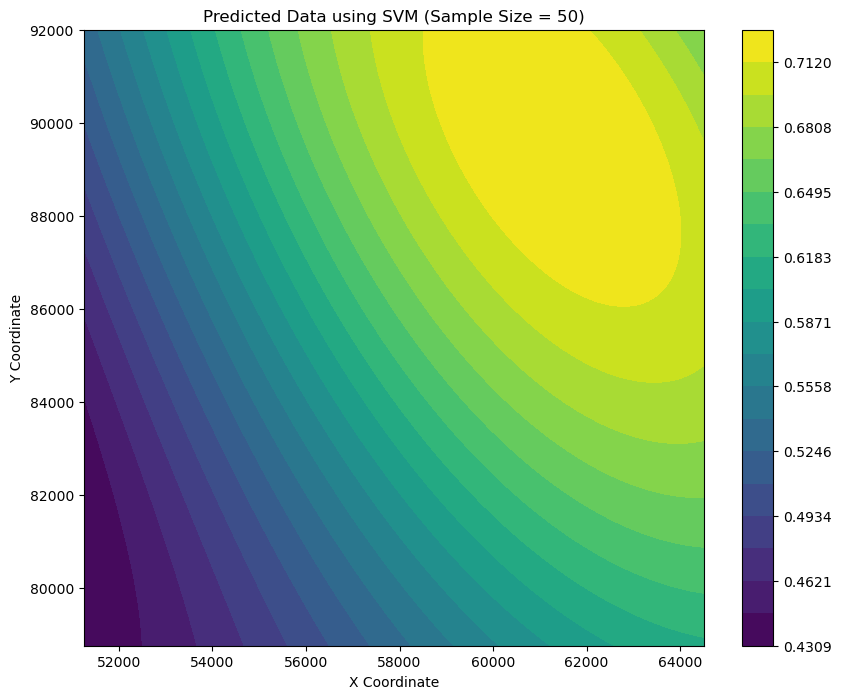

Sample Size = 50:
  MSE: 0.003576
  RMSE: 0.059803
  MAE: 0.049833
--------------------------------------------------


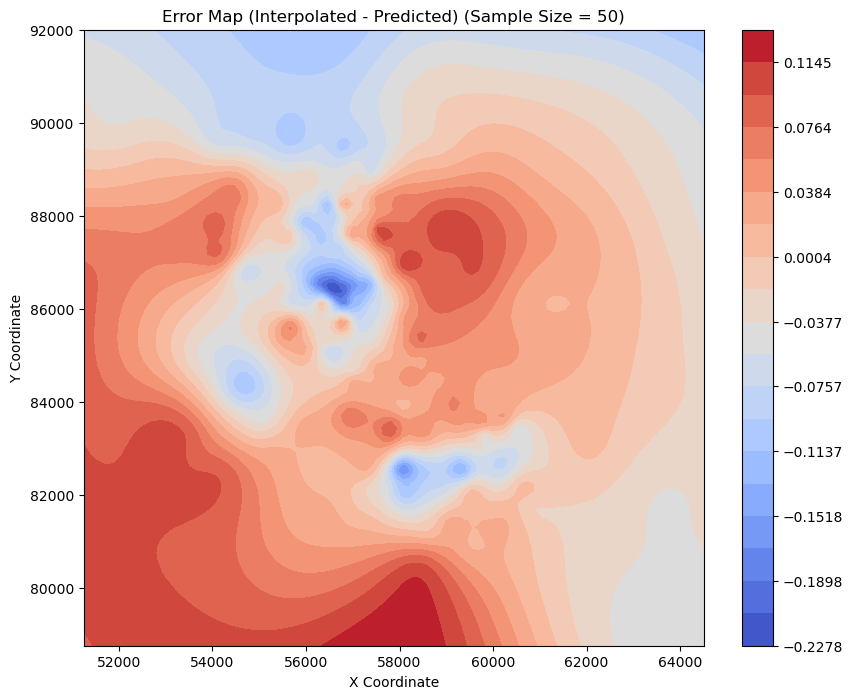

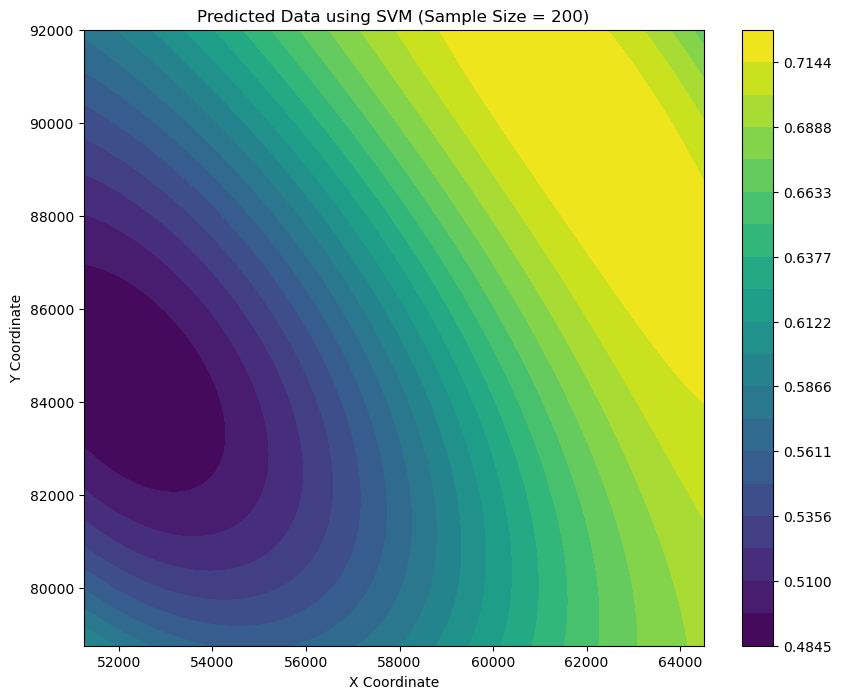

Sample Size = 200:
  MSE: 0.003420
  RMSE: 0.058477
  MAE: 0.049527
--------------------------------------------------


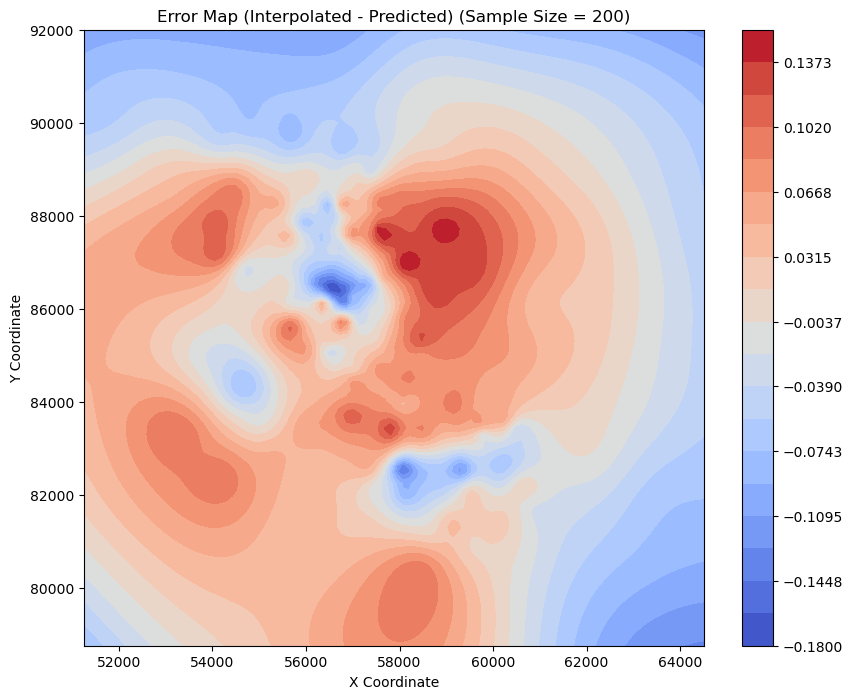

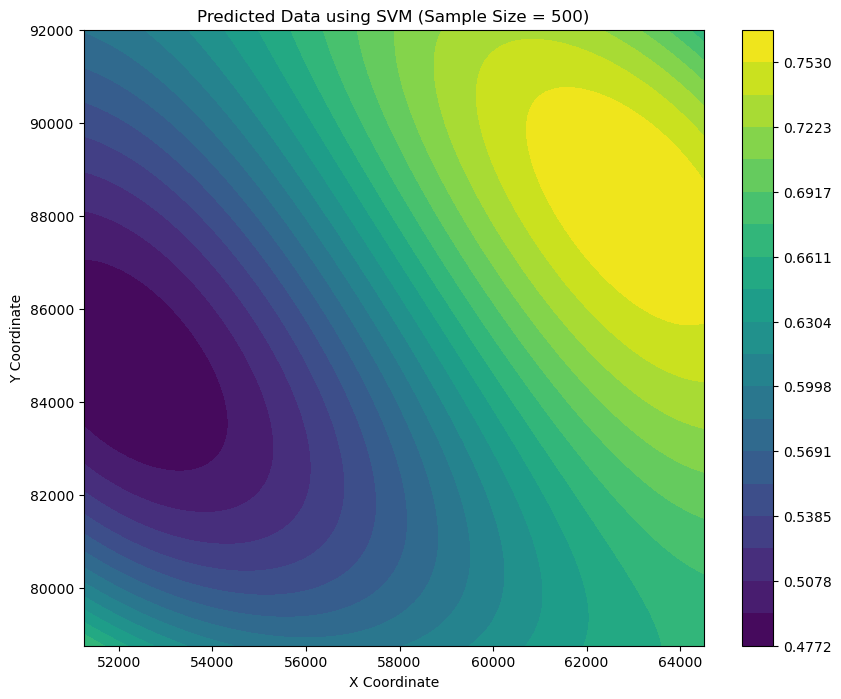

Sample Size = 500:
  MSE: 0.003490
  RMSE: 0.059077
  MAE: 0.051133
--------------------------------------------------


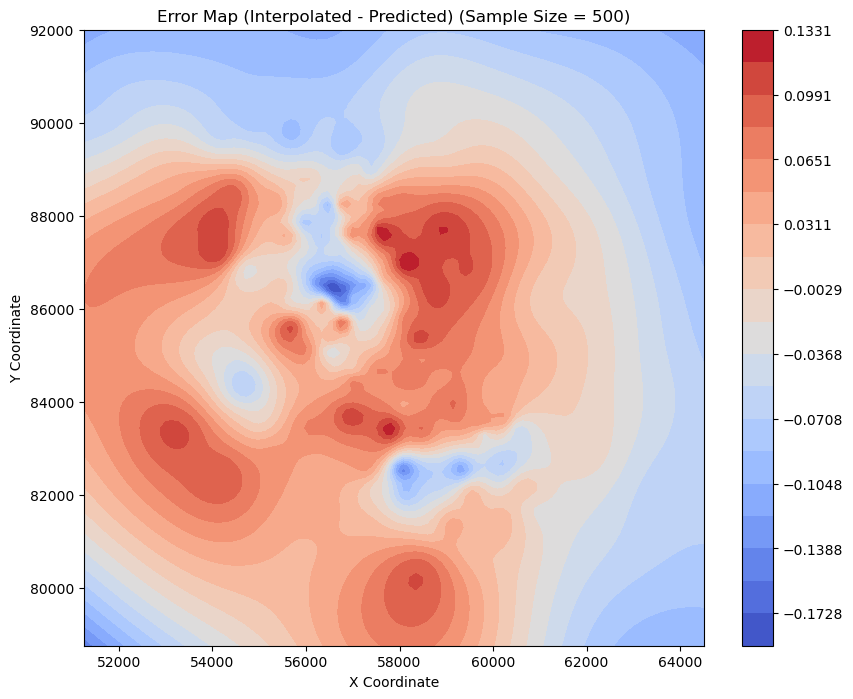

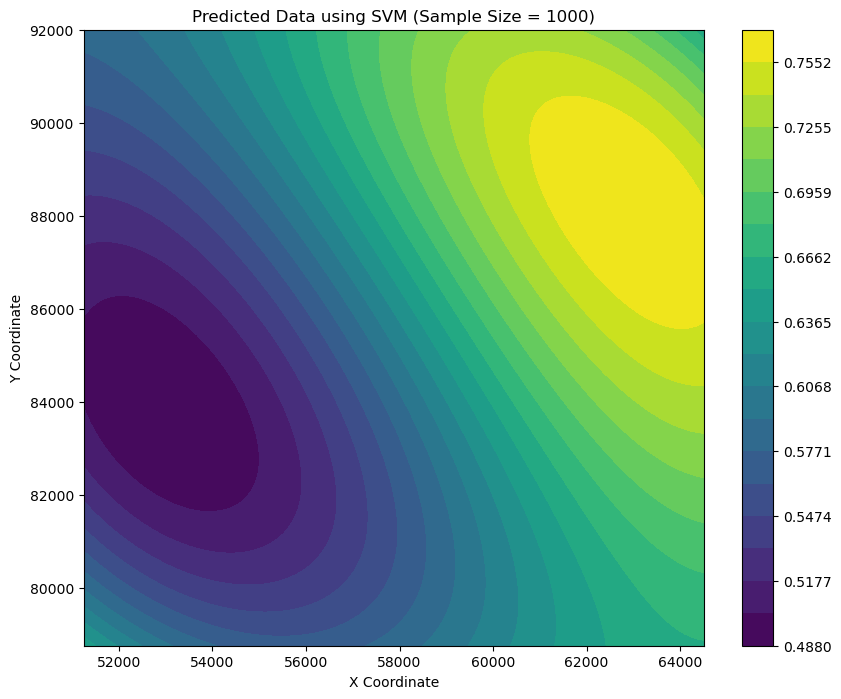

Sample Size = 1000:
  MSE: 0.003407
  RMSE: 0.058368
  MAE: 0.050837
--------------------------------------------------


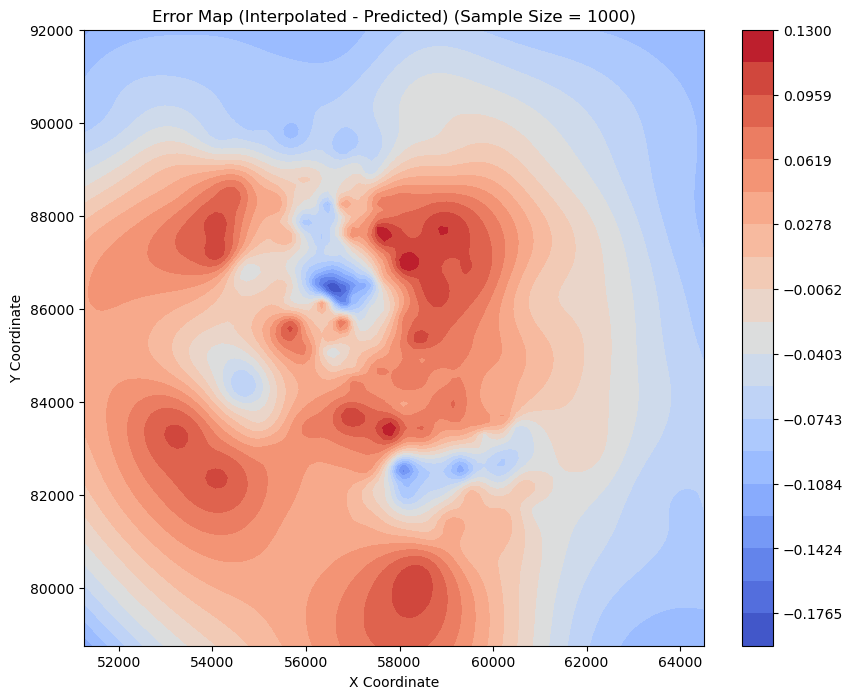

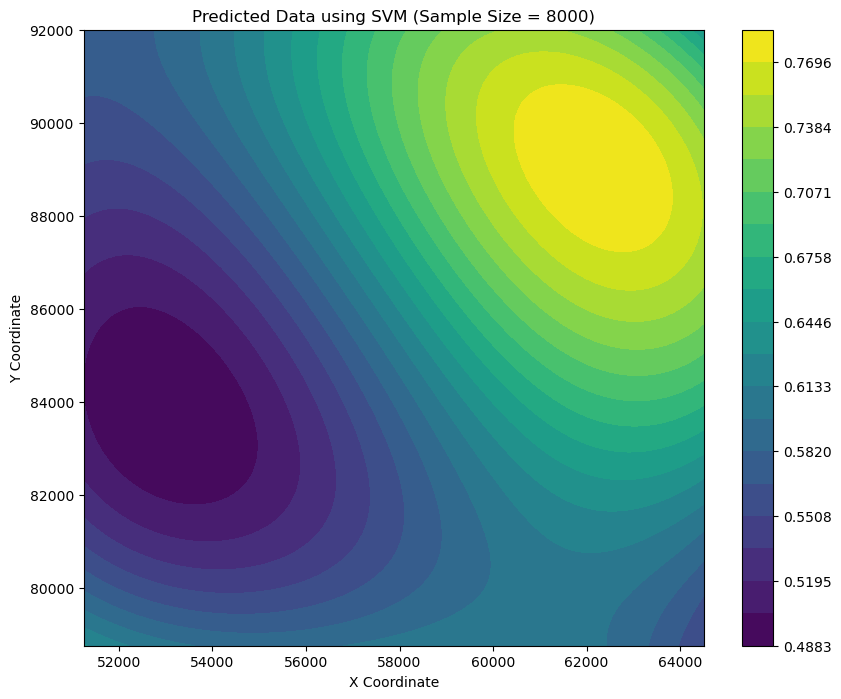

Sample Size = 8000:
  MSE: 0.002914
  RMSE: 0.053986
  MAE: 0.044774
--------------------------------------------------


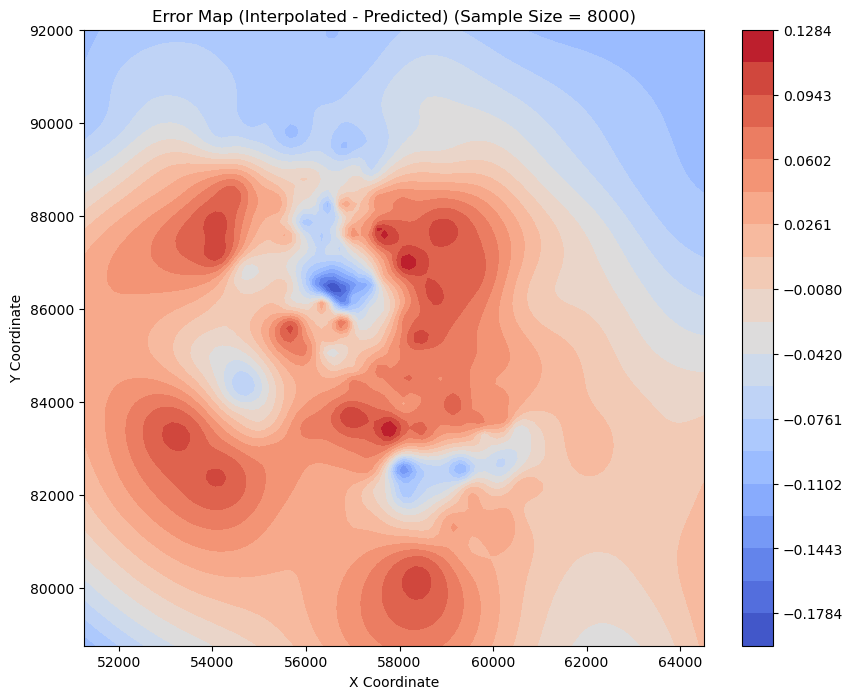

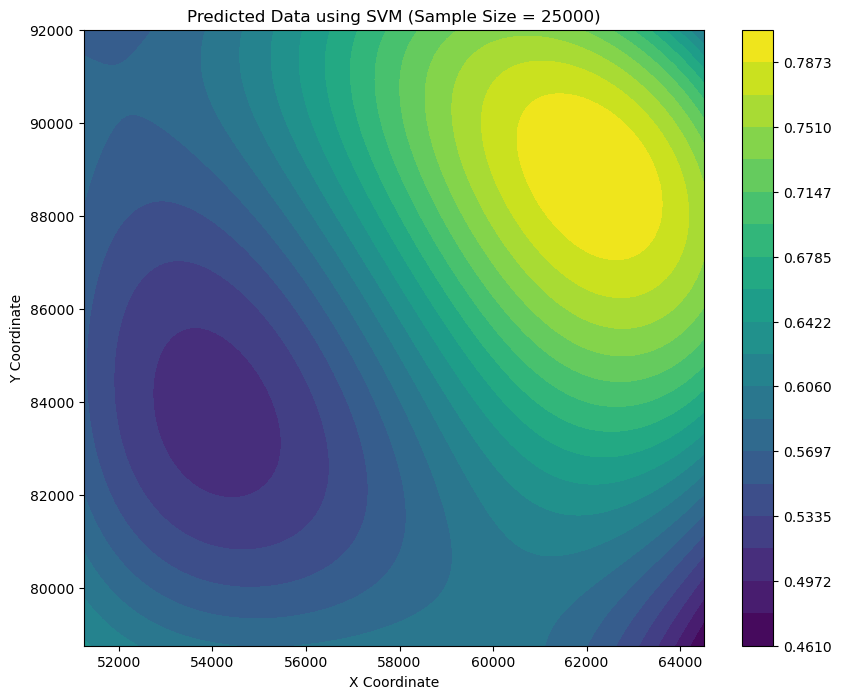

Sample Size = 25000:
  MSE: 0.002917
  RMSE: 0.054009
  MAE: 0.044643
--------------------------------------------------


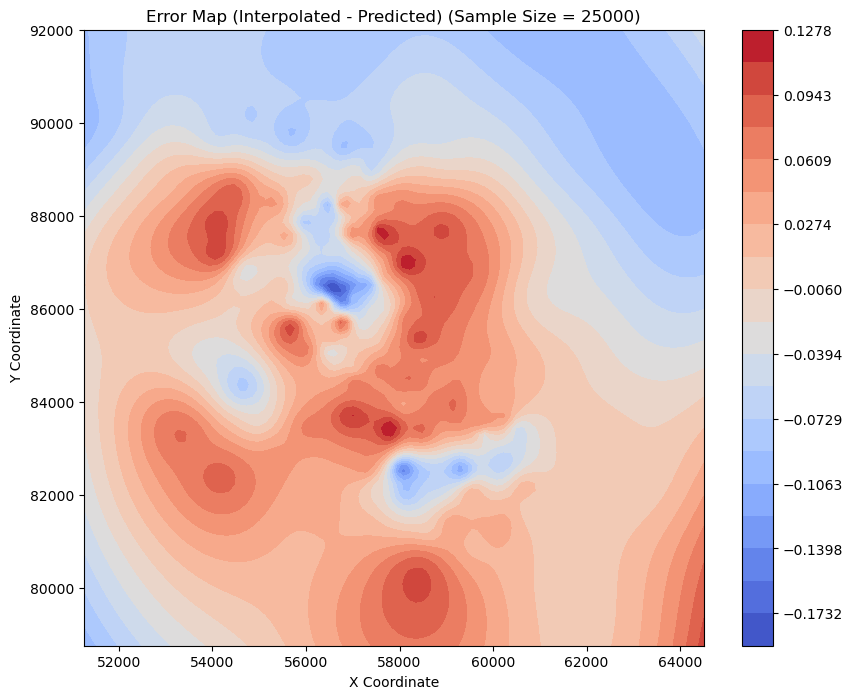

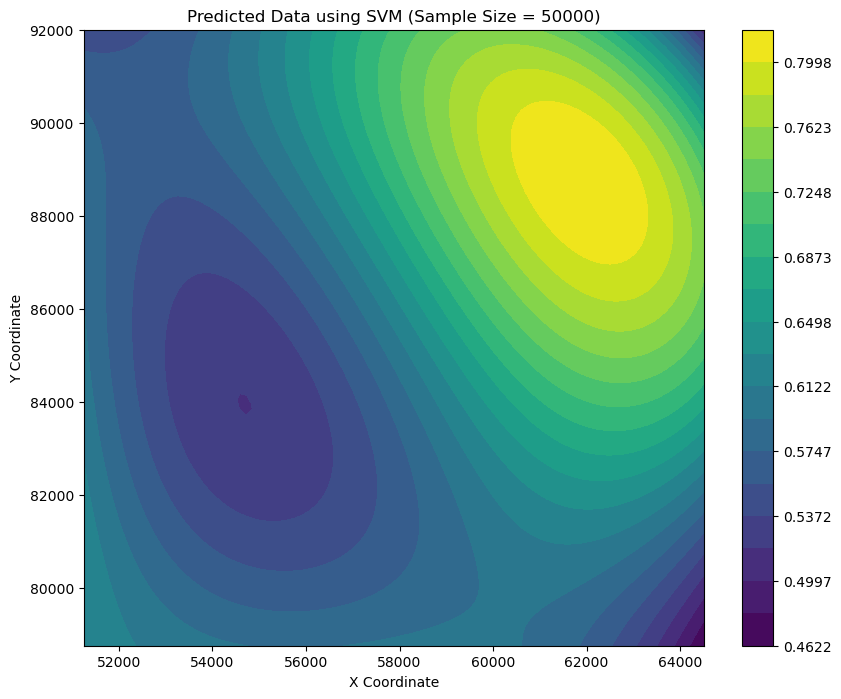

Sample Size = 50000:
  MSE: 0.002940
  RMSE: 0.054219
  MAE: 0.045339
--------------------------------------------------


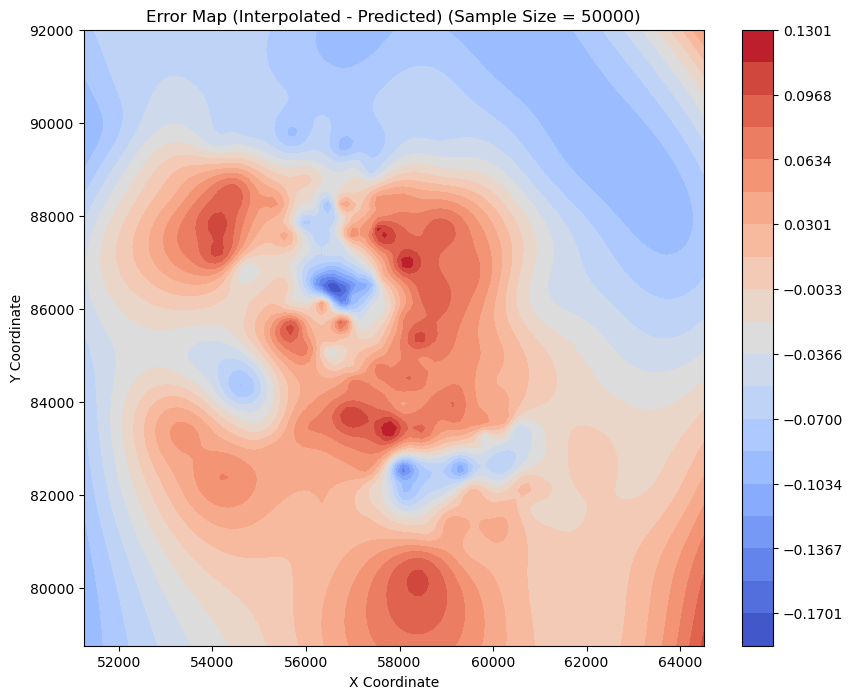

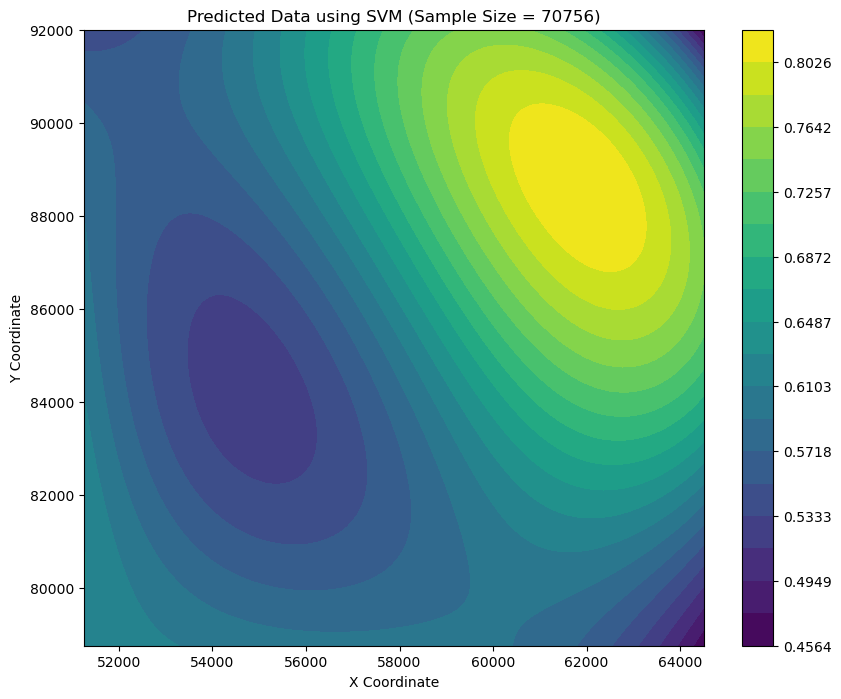

Sample Size = 70756:
  MSE: 0.003005
  RMSE: 0.054814
  MAE: 0.046080
--------------------------------------------------


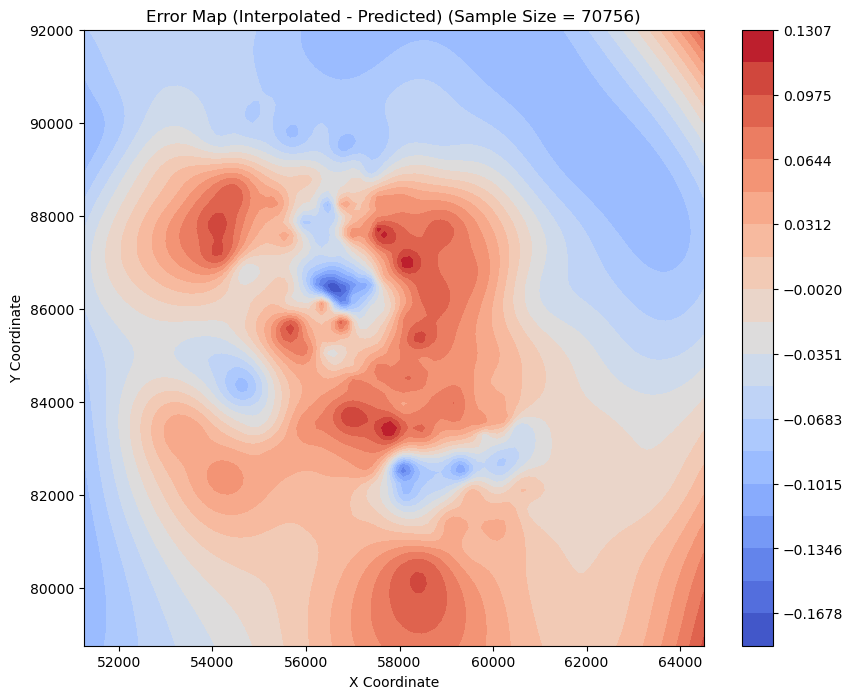

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy.interpolate import griddata
import random

np.random.seed(33)
random.seed(33)

# ------------------------------- 1. Data Loading ------------------------------- #

# Read the data
data = pd.read_csv('F1_target_variable.csv')
x = data['X_Coordinate']
y = data['Y_Coordinate']
z = data['Target Property']

# Prepare the coordinate data and target values for training
X_train = np.column_stack((x, y))
y_train = z

# ------------------------------- 2. SVM Model Training ------------------------------- #

sample_sizes = [50, 200, 500, 1000, 8000, 25000, 50000, len(x)] 

for sample_size in sample_sizes:
    # Choose a random sample of the data
    sample_indices = np.random.choice(len(x), sample_size, replace=False)
    x_sample = x.iloc[sample_indices]
    y_sample = y.iloc[sample_indices]
    z_sample = z.iloc[sample_indices]

    # Prepare the coordinates for training
    X_sample = np.column_stack((x_sample, y_sample))
    y_sample_target = z_sample

    # Train the SVM model on the random sample
    svm_model = SVR(kernel='rbf', C=100, epsilon=0.1)  # Using RBF kernel (can be tuned)
    svm_model.fit(X_sample, y_sample_target)

    # ------------------------------- 3. Prediction and Plot ------------------------------- #

    # Predict using the trained SVM model
    z_pred = svm_model.predict(X_sample)

    # Create a grid for the predicted data
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Use the trained SVM model to predict the grid points
    X_grid = np.column_stack((xi.flatten(), yi.flatten()))
    z_grid_pred = svm_model.predict(X_grid)
    z_grid_pred = z_grid_pred.reshape(xi.shape)

    # Plot the prediction results
    plt.figure(figsize=(10, 8))
    levels = np.linspace(np.nanmin(z_grid_pred), np.nanmax(z_grid_pred), 20)
    contour = plt.contourf(xi, yi, z_grid_pred, levels=levels, cmap='viridis') 
    plt.colorbar(contour)
    plt.title(f'Predicted Data using SVM (Sample Size = {sample_size})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Save the predicted data plot
    plt.savefig(f'Predicted_Data_SVM_Sample_Size_{sample_size}.png')
    plt.show()

    # ------------------------------- 4. Error Computation and Plot ------------------------------- #

    # Use griddata for interpolation to compare with SVM predictions
    z_interpolated = griddata((x, y), z, (xi, yi), method='linear')

    # Compute the error between SVM predictions and the interpolated data
    error = z_interpolated - z_grid_pred

    # Remove NaN values from error and predictions for validation
    valid_indices = ~np.isnan(error.flatten())
    error_valid = error.flatten()[valid_indices]
    z_interpolated_valid = z_interpolated.flatten()[valid_indices]
    z_grid_pred_valid = z_grid_pred.flatten()[valid_indices]

    # Compute error metrics
    mse = mean_squared_error(z_interpolated_valid, z_grid_pred_valid)
    rmse = sqrt(mse)
    mae = mean_absolute_error(z_interpolated_valid, z_grid_pred_valid)

    print(f"Sample Size = {sample_size}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print("-" * 50)

    # Plot the error map
    plt.figure(figsize=(10, 8))
    levels = np.linspace(np.nanmin(error_valid), np.nanmax(error_valid), 20)
    contour = plt.contourf(xi, yi, error, levels=levels, cmap='coolwarm')  
    plt.colorbar(contour) 
    plt.title(f'Error Map (Interpolated - Predicted) (Sample Size = {sample_size})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Save the error map plot
    plt.savefig(f'Error_Map_SVM_Sample_Size_{sample_size}.png')
    plt.show()
